# Daily Data

## Imports

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet

## Data Loading

In [5]:
# Load the data

muc_2008 = "./munich2008.csv"
muc_2009 = "./munich2009.csv"
muc_2010 = "./munich2010.csv"
muc_2011 = "./munich2011.csv"
muc_2012 = "./munich2012.csv"
muc_2013 = "./munich2013.csv"
muc_2014 = "./munich2014.csv"
muc_2015 = "./munich2015.csv"
muc_2016 = "./munich2016.csv"
muc_2017 = "./munich2017.csv"
muc_2018 = "./munich2018.csv"
muc_2019 = "./munich2019.csv"
muc_2020 = "./munich2020.csv"
muc_2021 = "./munich2021.csv"
muc_2022 = "./munich2022.csv"
muc_2023 = "./munich2023.csv"

# Read the data
df_muc_2008 = pd.read_csv(muc_2008)
df_muc_2009 = pd.read_csv(muc_2009)
df_muc_2010 = pd.read_csv(muc_2010)
df_muc_2011 = pd.read_csv(muc_2011)
df_muc_2012 = pd.read_csv(muc_2012)
df_muc_2013 = pd.read_csv(muc_2013)
df_muc_2014 = pd.read_csv(muc_2014)
df_muc_2015 = pd.read_csv(muc_2015)
df_muc_2016 = pd.read_csv(muc_2016)
df_muc_2017 = pd.read_csv(muc_2017)
df_muc_2018 = pd.read_csv(muc_2018)
df_muc_2019 = pd.read_csv(muc_2019)
df_muc_2020 = pd.read_csv(muc_2020)
df_muc_2021 = pd.read_csv(muc_2021)
df_muc_2022 = pd.read_csv(muc_2022)
df_muc_2023 = pd.read_csv(muc_2023)

# Change date format to YYYY-MM-DD
df_muc_2023['datum'] = df_muc_2023['datum'].apply(lambda x: datetime.strptime(x, '%Y.%m.%d').strftime('%Y-%m-%d'))

# Concatenate the data
df_munich = pd.concat(
    [df_muc_2008, 
     df_muc_2009, 
     df_muc_2010, 
     df_muc_2011, 
     df_muc_2012, 
     df_muc_2013, 
     df_muc_2014, 
     df_muc_2015,
     df_muc_2016,
     df_muc_2017,
     df_muc_2018,
     df_muc_2019,
     df_muc_2020,
     df_muc_2021,
     df_muc_2022, 
     df_muc_2023], 
    ignore_index=True)

# List of columns to drop, as they are not needed for the analysis and visualization of the data
columns_to_drop = ['uhrzeit_start', 'uhrzeit_ende', 'kommentar', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden']

# Rename the columns to make them more readable and easier to work with
df_munich = df_munich.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'min.temp':'MinTemp',
    'max.temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Drop the columns that are not needed
df_munich = df_munich.drop(columns=columns_to_drop)

# Sort the data by date in ascending order to make it easier to work with the time series data later
df_munich = df_munich.sort_values(by='Date')

# Convert the date column to datetime format
df_munich['Date'] = pd.to_datetime(df_munich['Date'])

# Calculate average temperature from min and max temperature columns and add it to the dataframe as a new column called 'AvgTemp'
df_munich['AvgTemp'] = (df_munich['MinTemp'] + df_munich['MaxTemp']) / 2

# Create a new dataframe for the selected location (Erhardt) and reset the index
df_location_erhardt = df_munich[df_munich['Location']=='Erhardt'].reset_index()

# Drop the index column as it is not needed and rename the columns to make them more readable
df_location_erhardt = df_location_erhardt.drop(columns=['Location','index'])

# Round the average temperature to one decimal place
df_location_erhardt['AvgTemp'] = df_location_erhardt['AvgTemp'].round(1)

# Convert the date column to datetime format
df_location_erhardt['Date'] = pd.to_datetime(df_location_erhardt['Date'])

# Add a calculated column for the Day of the Week
df_location_erhardt['DayOfWeek'] = df_location_erhardt['Date'].dt.dayofweek + 1  # Adding 1 to have Monday as 1

# Add a calculated column for the Month
df_location_erhardt['Month'] = df_location_erhardt['Date'].dt.month

# Add a calculated column for the Year
df_location_erhardt['Year'] = df_location_erhardt['Date'].dt.year

df_m_e_model = df_location_erhardt[['Date','Total']]

# Set the date column as the index
df_m_e_model = df_m_e_model.set_index(['Date'])

# Set the date column as the index
df_location_erhardt = df_location_erhardt.set_index(['Date'])

# Set the frequency of the index to daily (D) as the data is daily
df_m_e_model.index.freq = 'D'

# Set the frequency of the index to daily (D) as the data is daily
df_location_erhardt.index.freq = 'D'

In [6]:
# Remove the NaN values from the data as they are not needed for the analysis
df_location_erhardt = df_location_erhardt.dropna()
# print(df_location_erhardt.describe())
# Save the data to a new CSV file
df_location_erhardt.to_csv('munich_erhardt.csv')

# Calculate Q1 (25th percentile) and Q3 (75th percentile) of the 'Total' column
Q1 = df_location_erhardt['Total'].quantile(0.25)
Q3 = df_location_erhardt['Total'].quantile(0.75)
IQR = Q3 - Q1

# Define thresholds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = df_location_erhardt[(df_location_erhardt['Total'] < lower_bound) | (df_location_erhardt['Total'] > upper_bound)]
print("Number of outliers detected:", len(outliers))
print("Number of rows before outliers removed:", len(df_location_erhardt))

# Removing outliers for testing purposes
# df_location_erhardt = df_location_erhardt[(df_location_erhardt['Total'] > lower_bound) & (df_location_erhardt['Total'] < upper_bound)]
print("Number of rows after outliers removed:", len(df_location_erhardt))
copy_df_location_erhardt = df_location_erhardt.copy()
copy_df_location_erhardt

Number of outliers detected: 9
Number of rows before outliers removed: 4543
Number of rows after outliers removed: 4543


,Total,MinTemp,MaxTemp,RainfallVolume,AvgTemp,DayOfWeek,Month,Year
Date,,,,,,,,
2011-07-25,1823.0,6.9,19.0,0.0,13.0,1,7,2011
2011-07-26,6167.0,8.1,22.7,0.0,15.4,2,7,2011
2011-07-27,6294.0,8.0,24.4,0.0,16.2,3,7,2011
2011-07-28,3943.0,12.9,23.7,31.0,18.3,4,7,2011
2011-07-29,3562.0,14.5,22.2,5.2,18.4,5,7,2011
...,...,...,...,...,...,...,...,...
2023-12-27,1583.0,1.9,11.3,0.0,6.6,3,12,2023
2023-12-28,1810.0,2.6,12.0,0.0,7.3,4,12,2023
2023-12-29,1898.0,7.5,11.2,0.0,9.4,5,12,2023


## Overview of Total Bike Count and Average Temperature

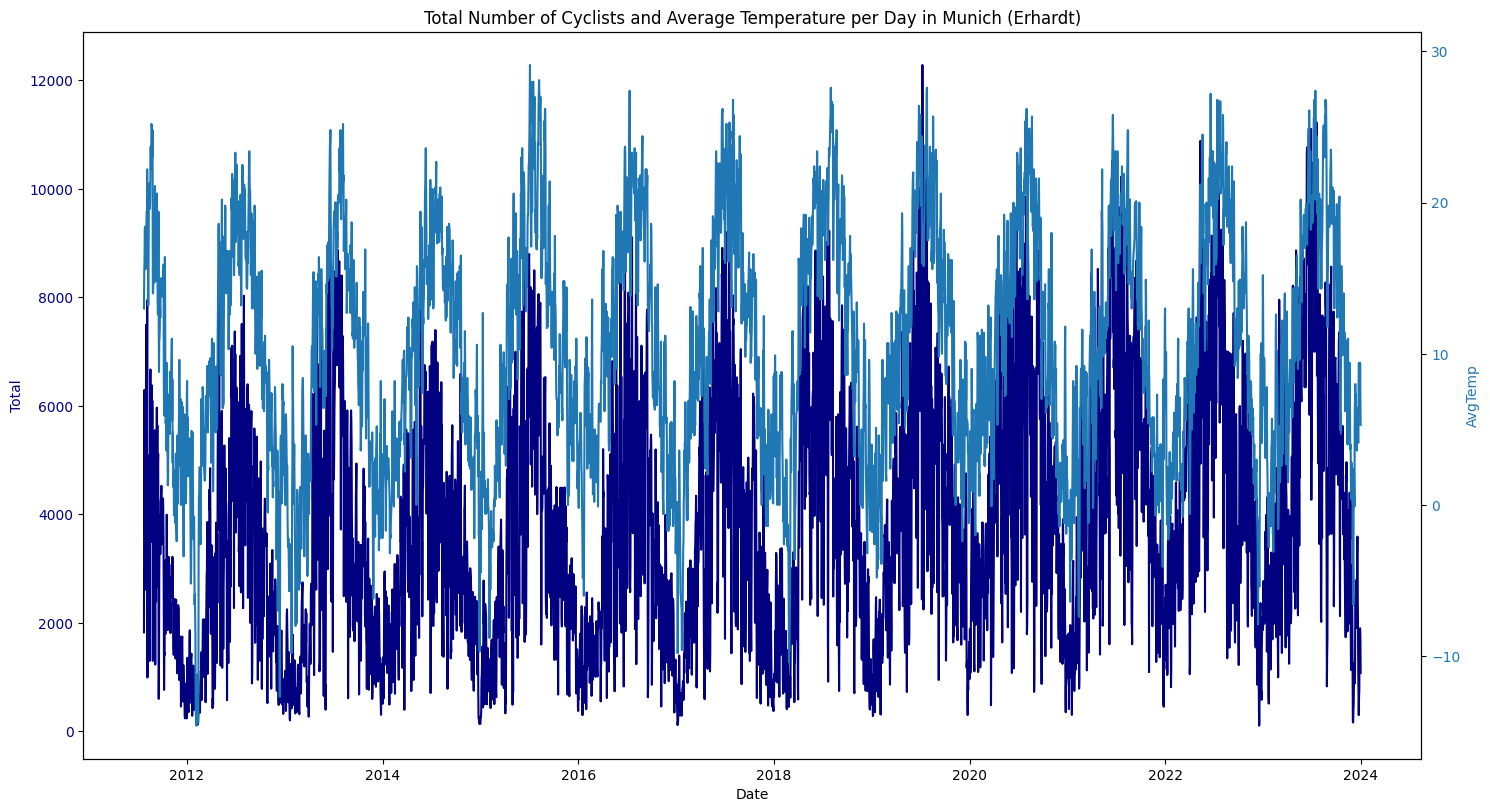

In [7]:
# Plot the total number of cyclists per day and the average temperature per day for the selected location (Erhardt) in Munich
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.set_xlabel('Date')
ax1.set_ylabel('Total', color='navy')
ax1.plot(df_location_erhardt.index, df_location_erhardt['Total'], color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('AvgTemp', color=color)
ax2.plot(df_location_erhardt.index, df_location_erhardt['AvgTemp'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('Total Number of Cyclists and Average Temperature per Day in Munich (Erhardt)')
plt.show()


## VAR (Vector Autoregression)

In [9]:
# Check stationarity of the time series data using the Augmented Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
# Perform the Augmented Dickey-Fuller test on the total number of cyclists per day
adf_test(df_location_erhardt['Total'])


Results of Dickey-Fuller Test:
Test Statistic                   -4.457614
p-value                           0.000234
#Lags Used                       29.000000
Number of Observations Used    4513.000000
Critical Value (1%)              -3.431800
Critical Value (5%)              -2.862181
Critical Value (10%)             -2.567111
dtype: float64


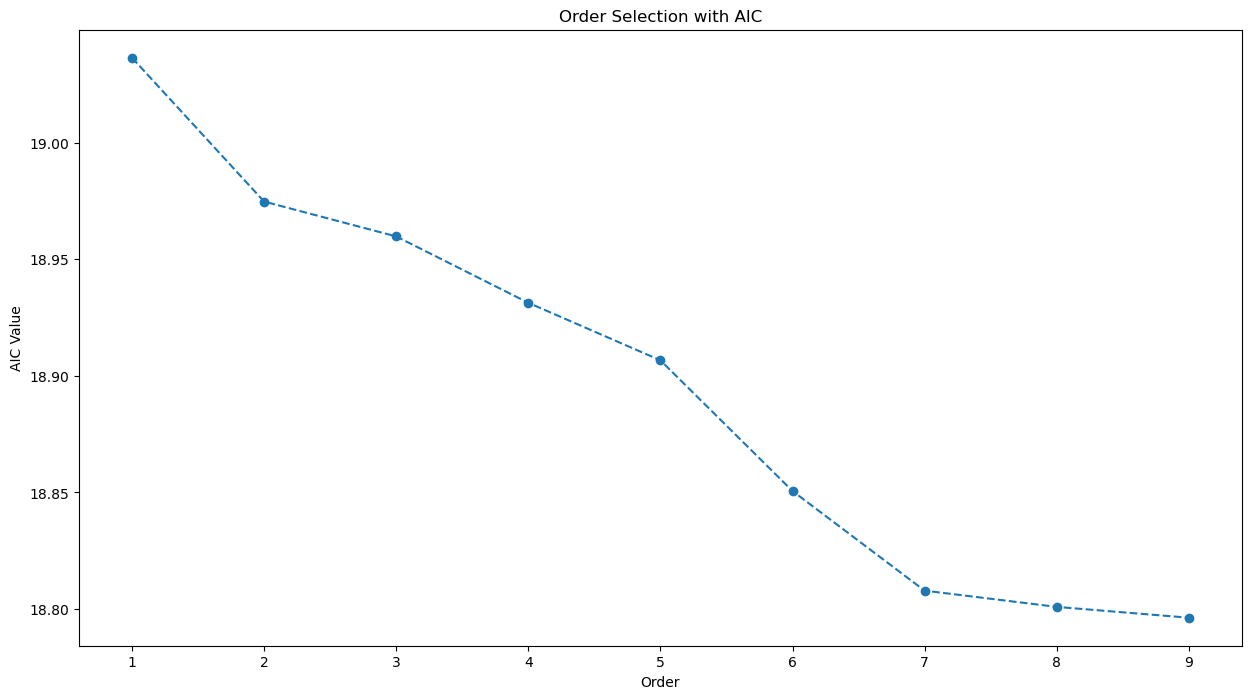

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 17, Mar, 2024
Time:                     10:22:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.9152
Nobs:                     4534.00    HQIC:                   18.8382
Log likelihood:          -61827.6    FPE:                1.45590e+08
AIC:                      18.7963    Det(Omega_mle):     1.42926e+08
--------------------------------------------------------------------
Results for equation Total
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                   250.290606        47.645588            5.253           0.000
L1.Total                  0.507447         0.018065           28.091           0.000
L1.AvgTemp               16.153694         8

/Users/caropaez/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


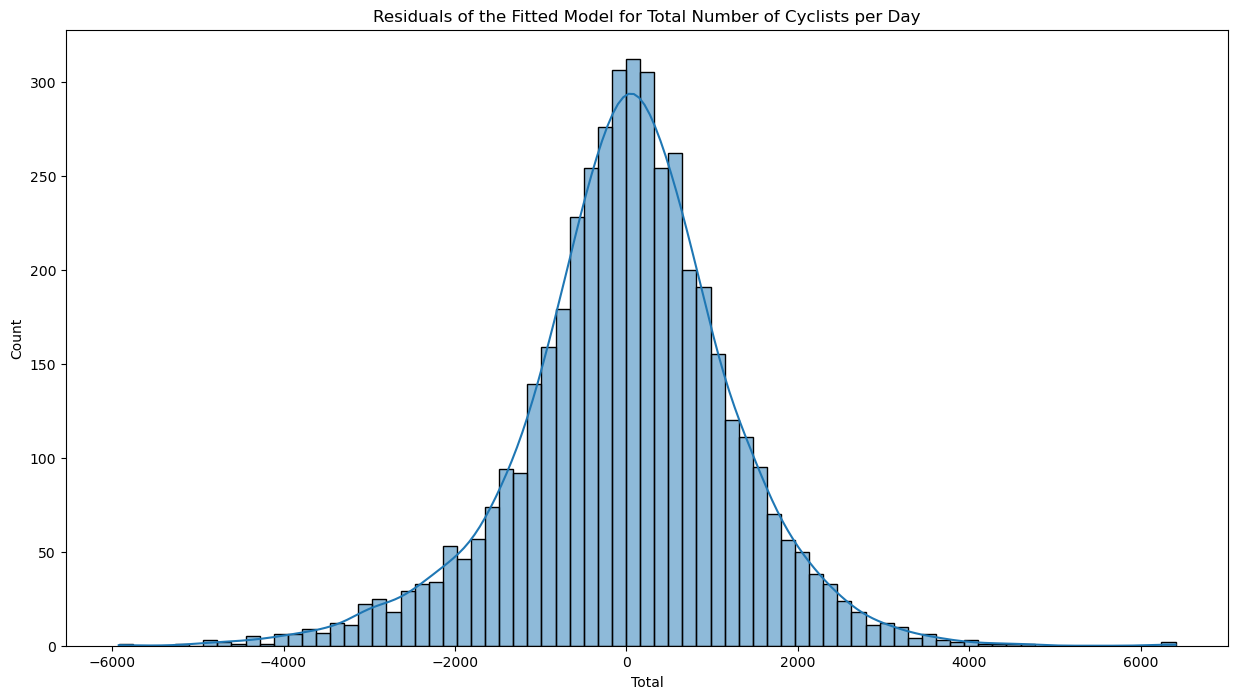

In [162]:
model = VAR(df_location_erhardt[['Total', 'AvgTemp','RainfallVolume']])
aic_vals = []
for i in range(1, 10):
    result = model.fit(i)
    aic_vals.append(result.aic)
optimal_lag = np.argmin(aic_vals) + 1

# visualize the AIC values
plt.figure(figsize=(15, 8))
plt.plot(range(1, 10), aic_vals, marker='o', linestyle='--')
plt.xlabel('Order')
plt.ylabel('AIC Value')
plt.title('Order Selection with AIC')
plt.show()

fitted_model = model.fit(optimal_lag)

# Print the summary of the fitted model
print(fitted_model.summary())

# Model diagnostics
# Check the residuals of the model for normality
residuals = fitted_model.resid
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(residuals['Total'], kde=True, ax=ax)
plt.title('Residuals of the Fitted Model for Total Number of Cyclists per Day')
plt.show()


When adding the RainfallVolume to your VAR model, it appears to significantly affect the residuals of the Total variable. Including RainfallVolume has changed the dynamics of the model, as seen by the coefficients associated with the lagged values of RainfallVolume in predicting Total counts. Notably, the L1.RainfallVolume coefficient is significant and negative, indicating that, as expected, rainfall has an immediate negative effect on bicycle counts.
<br><br>
The AIC (Akaike Information Criterion) value in the model without RainfallVolume was slightly lower (indicating a potentially better fit), but this doesn't necessarily mean the model without RainfallVolume is better overall. It may mean that including RainfallVolume adds complexity without enough added explanatory power for the increase in the number of parameters. However, the model with RainfallVolume provides a more complete picture, as it captures the influence of weather on cycling behavior, which is an important factor.
<br><br>
In the updated model with RainfallVolume, we also see significant coefficients for RainfallVolume at different lags for predicting itself, which makes sense given that weather can have serial correlation (rain one day can be related to rain on previous or subsequent days).
<br><br>
The correlation matrix of residuals shows the relationships between the errors of the equations after accounting for the modeled relationships. Ideally, we'd want these to be close to zero, meaning that the model has accounted for the relationships between the variables effectively, and what's left (the errors) are random noise. However, Total and AvgTemp show a positive correlation, while Total and RainfallVolume have a negative correlation in the residuals, indicating potential relationships that the model hasn't fully captured.
<br><br>
Regarding the high correlation between Total and AvgTemp and the negative correlation between Total and RainfallVolume, these make sense intuitively. More people are likely to cycle on warmer days and less likely to cycle when it rains.
<br><br>
The RMSE values provide a measure of the average magnitude of the forecast errors. A lower RMSE value is better as it indicates closer fits to the actual data. Comparing RMSE values before and after including RainfallVolume can tell you whether including it has improved the predictive accuracy of the model. From the values you've posted, it seems there was a significant improvement in RMSE for the Total variable after including RainfallVolume.

In [163]:
from statsmodels.stats.stattools import durbin_watson

# Fit the VAR model
var_model = VAR(df_location_erhardt[['Total', 'MinTemp', 'MaxTemp', 'RainfallVolume', 'AvgTemp', 'DayOfWeek', 'Month', 'Year']])
var_results = var_model.fit(optimal_lag)

# Get the residuals
residuals = var_results.resid

# Get the Durbin-Watson statistic for each variable
dw_stats = durbin_watson(residuals)

# Match the statistic to each variable name
for var_name, dw_stat in zip(df_location_erhardt.columns, dw_stats):
    print(f'{var_name}: {dw_stat:.2f}')


Total: 2.00
MinTemp: 2.00
MaxTemp: 2.00
RainfallVolume: 2.00
AvgTemp: 2.00
DayOfWeek: 0.35
Month: 2.00
Year: 2.00


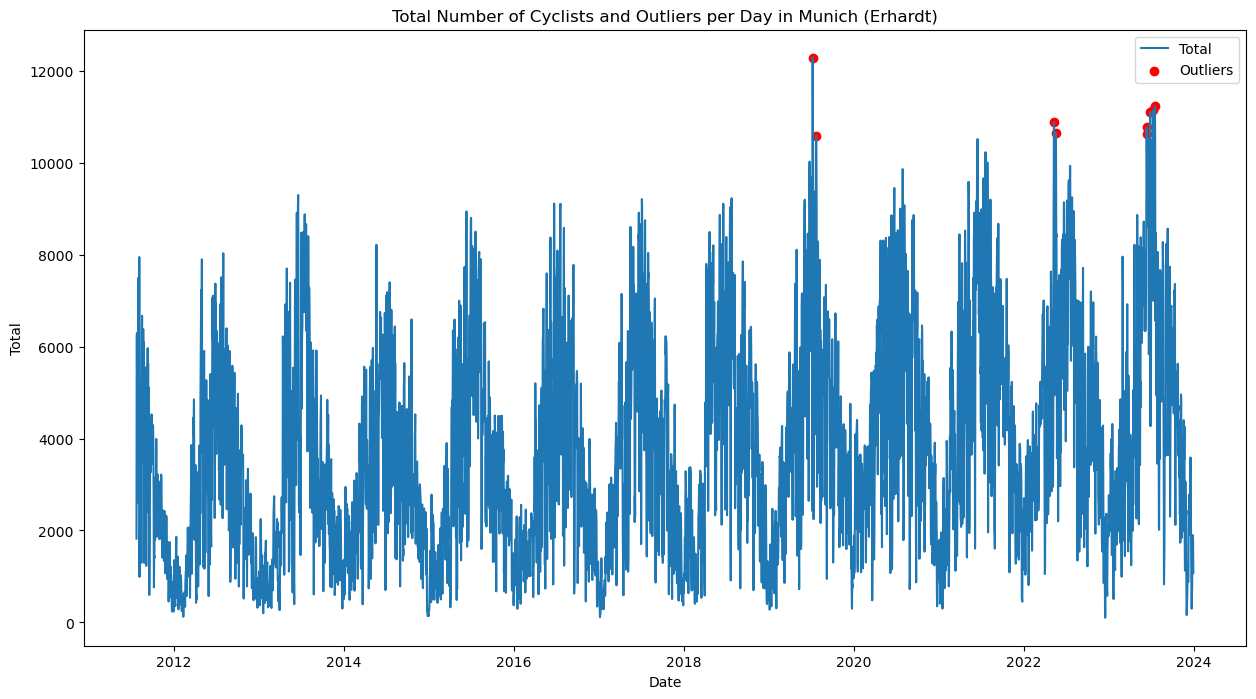

In [164]:

# Z-score method
from scipy import stats


z_scores = np.abs(stats.zscore(df_location_erhardt['Total']))
outliers = np.where(z_scores > 3)

# IQR method
Q1 = df_location_erhardt['Total'].quantile(0.25)
Q3 = df_location_erhardt['Total'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df_location_erhardt['Total'] < (Q1 - 1.5 * IQR)) | (df_location_erhardt['Total'] > (Q3 + 1.5 * IQR))
outliers = df_location_erhardt.loc[outlier_condition]

# Visualize the outliers
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.scatter(outliers.index, outliers['Total'], color='red', label='Outliers')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists and Outliers per Day in Munich (Erhardt)')
plt.show()



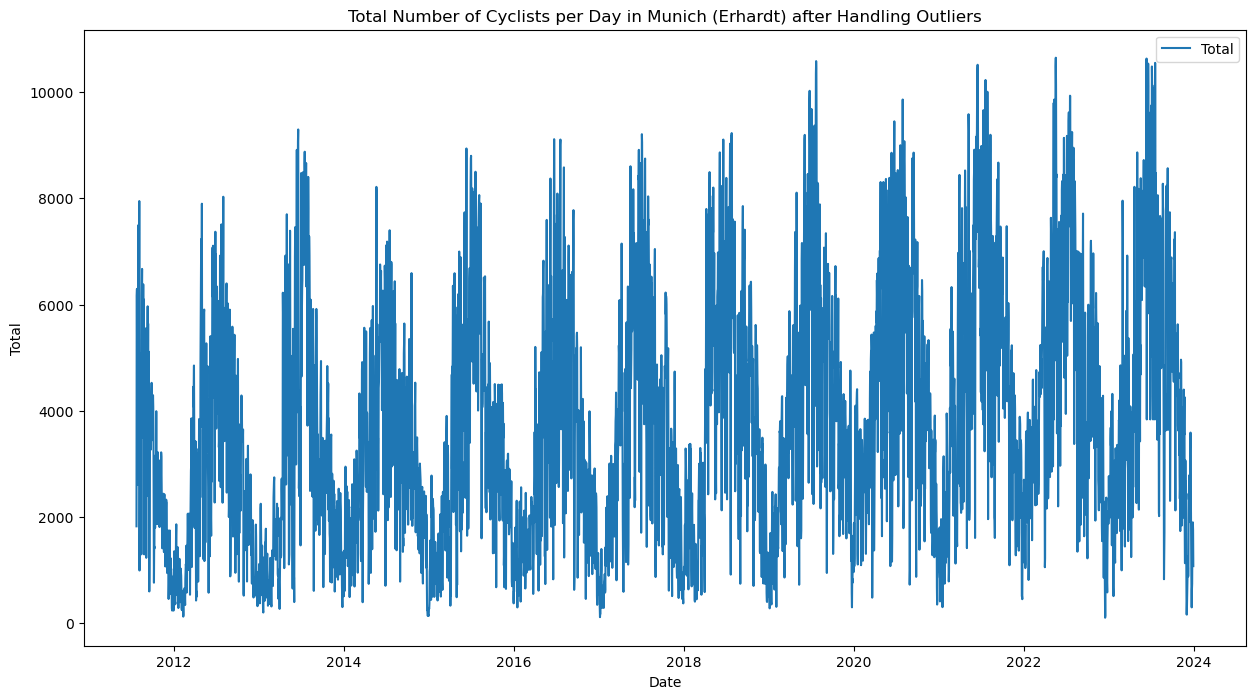

In [165]:
# Handle the outliers by replacing them with the mean of the total number of cyclists per day in the dataset using the z-score method
df_location_erhardt['Total'] = np.where(z_scores > 3, df_location_erhardt['Total'].mean(), df_location_erhardt['Total'])

# Visualize the total number of cyclists per day after handling the outliers
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists per Day in Munich (Erhardt) after Handling Outliers')
plt.show()


In [166]:
# Select only the necessary columns for fitting the VAR model
df_m_e_model = df_location_erhardt
# Fit the VAR model
var_model = VAR(df_m_e_model)
var_results = var_model.fit(maxlags=15, ic=None)

# Find the optimal lag length based on information criteria
lag_order_selection = model.select_order(maxlags=18)
print(lag_order_selection.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        21.92       21.93   3.325e+09       21.93
1        19.03       19.04   1.833e+08       19.03
2        18.96       18.99   1.721e+08       18.97
3        18.95       18.99   1.696e+08       18.96
4        18.93       18.98   1.658e+08       18.95
5        18.90       18.97   1.618e+08       18.93
6        18.85       18.93   1.530e+08       18.87
7        18.80      18.90*   1.465e+08       18.84
8        18.79       18.90   1.454e+08       18.83
9        18.79       18.91   1.447e+08      18.83*
10       18.79       18.92   1.449e+08       18.84
11       18.79       18.94   1.451e+08       18.84
12       18.79       18.95   1.447e+08       18.85
13       18.78       18.95   1.434e+08       18.84
14       18.77       18.95   1.416e+08       18.83
15       18.77       18.96   1.414e+08       18.84
16       18.76       18.97   1.

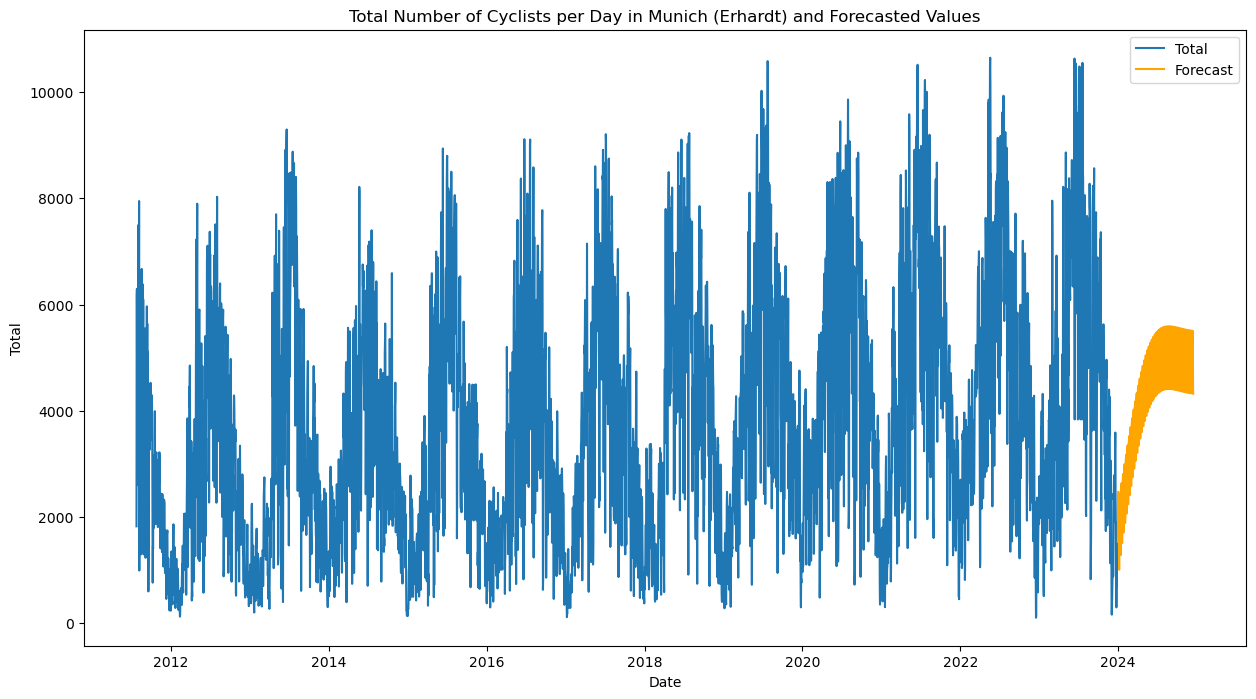

In [167]:
optimal_lag = 15  # Based on the AIC
fitted_model = var_model.fit(optimal_lag)

# To make predictions:
lag_order = fitted_model.k_ar
forecast_input = df_location_erhardt.values[-lag_order:]
forecast_result = fitted_model.forecast(y=forecast_input, steps=350)

# Visualize the forecasted values
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_location_erhardt.index, df_location_erhardt['Total'], label='Total')
ax.plot(pd.date_range(start=df_location_erhardt.index[-1], periods=350), forecast_result[:, 0], label='Forecast', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Total')
ax.legend()
plt.title('Total Number of Cyclists per Day in Munich (Erhardt) and Forecasted Values')
plt.show()


In [168]:
from scipy.stats import shapiro

# residuals of the fitted model
residuals = fitted_model.resid

# Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals['Total'])
print(f'Shapiro-Wilk Test Statistic: {shapiro_test[0]:.2f}, p-value: {shapiro_test[1]:.2f}')
# Interpret the test result
alpha = 0.05
if shapiro_test[1] > alpha:
    print('Residuals are normally distributed (fail to reject H0)')
else:
    print('Residuals are not normally distributed (reject H0)')
    
# Check for stability of the model
if fitted_model.is_stable():
    print('Model is stable')
else:
    print('Model is not stable')


Shapiro-Wilk Test Statistic: 0.98, p-value: 0.00
Residuals are not normally distributed (reject H0)
Model is not stable


# Neural Network

In [10]:
# To activate this environment, use
#
#     $ conda activate thesisenv
#
# To deactivate an active environment, use
#
#     $ conda deactivate

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [11]:
# Assuming df_location_erhardt is your DataFrame and is already loaded
# Ensure the DataFrame only contains the columns you're interested in
df = df_location_erhardt[['Total', 'MinTemp', 'MaxTemp', 'RainfallVolume', 'AvgTemp', 'DayOfWeek', 'Month', 'Year']]

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# Specify the number of lag n_days
n_hours = 1
n_features = df.shape[1]
# Frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.7)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))



### Model first try

In [12]:
# Define LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_hours, n_features)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

### Model Second Try

In [13]:
# Define the LSTM model
model = Sequential()
# First LSTM layer with Dropout regularisation
# model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'))
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_hours, n_features), activation='tanh'))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

# Using MSE loss function and the Adam optimizer with a learning rate schedule
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Alternatively, using MAE loss function which is more robust to outliers
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')


### Model 3rd try

In [14]:
# Define the LSTM model
model = Sequential()
# First LSTM layer with Dropout regularisation
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_hours, n_features), activation='relu'))
model.add(Dropout(0.2))
# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
# Third LSTM layer
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

# Using MSE loss function and the Adam optimizer with a learning rate schedule
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Alternatively, using MAE loss function which is more robust to outliers
model.compile(optimizer=Adam(learning_rate=0.003), loss='mean_absolute_error')


## Plot the results ML

Epoch 1/100
32/32 - 1s - loss: 0.1602 - val_loss: 0.1425 - 1s/epoch - 41ms/step
Epoch 2/100
32/32 - 0s - loss: 0.1250 - val_loss: 0.1134 - 76ms/epoch - 2ms/step
Epoch 3/100
32/32 - 0s - loss: 0.1052 - val_loss: 0.1133 - 73ms/epoch - 2ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0901 - val_loss: 0.1026 - 72ms/epoch - 2ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0892 - val_loss: 0.0976 - 71ms/epoch - 2ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0876 - val_loss: 0.0968 - 72ms/epoch - 2ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0852 - val_loss: 0.0951 - 75ms/epoch - 2ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0852 - val_loss: 0.0946 - 73ms/epoch - 2ms/step
Epoch 9/100
32/32 - 0s - loss: 0.0824 - val_loss: 0.0940 - 75ms/epoch - 2ms/step
Epoch 10/100
32/32 - 0s - loss: 0.0825 - val_loss: 0.0925 - 81ms/epoch - 3ms/step
Epoch 11/100
32/32 - 0s - loss: 0.0839 - val_loss: 0.0942 - 80ms/epoch - 2ms/step
Epoch 12/100
32/32 - 0s - loss: 0.0814 - val_loss: 0.0919 - 77ms/epoch - 2ms/step
Epoch 13/100
32/32 - 0s - 

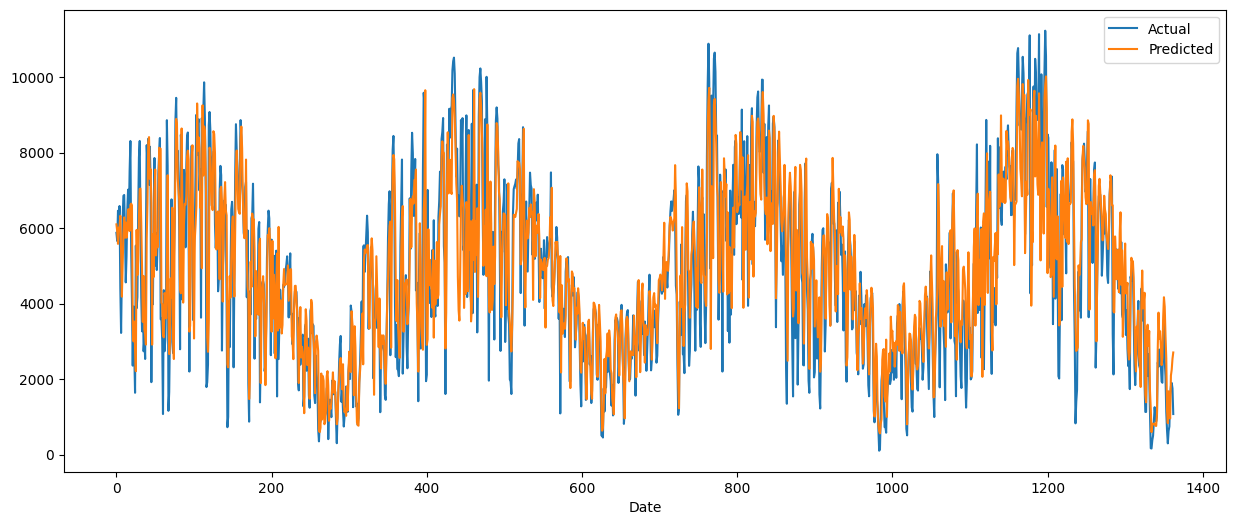

In [15]:
# Fit model
model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)  # Adjust based on the number of features used
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)  # Adjust based on the number of features used
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

# Calculate MAE
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

# Plotting the results
plt.figure(figsize=(15, 6))
plt.plot(inv_y, label='Actual')
plt.plot(inv_yhat, label='Predicted')
plt.xlabel('Date')
plt.legend()
plt.show()

# Prophet model 

## Part 1

/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpg2f05ukb/5xf1rcs8.json
DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpg2f05ukb/diurnnrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59871', 'data', 'file=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpg2f05ukb/5xf1rcs8.json', 'init=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpg2f05ukb/diurnnrp.json

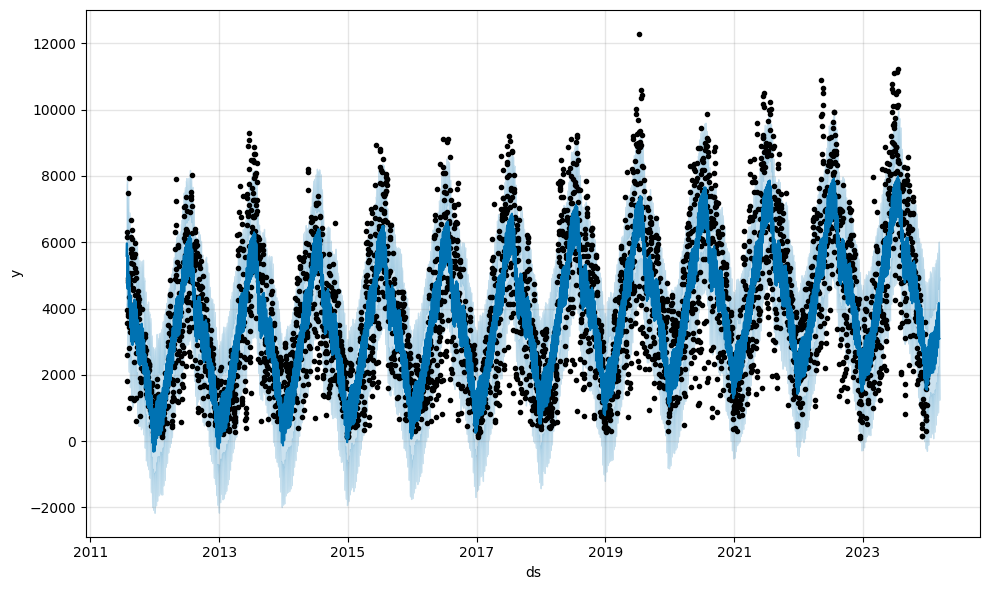

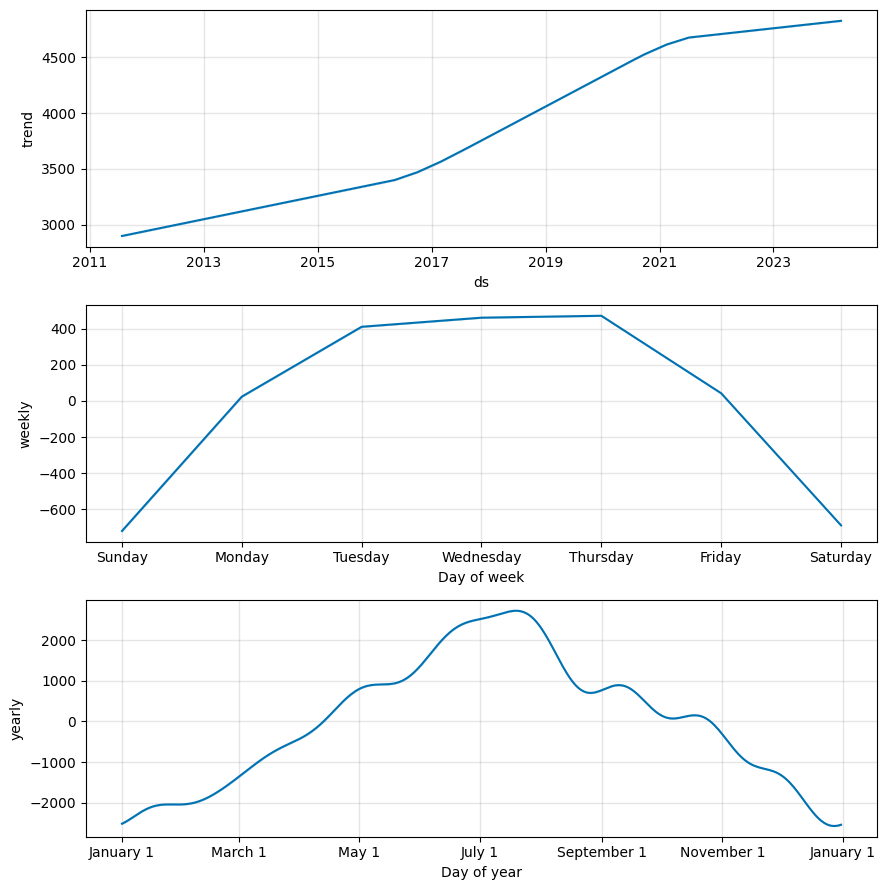

In [16]:
# Prepare the data for the Prophet model
df_prophet = df_location_erhardt.reset_index()
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Total': 'y'})
df_prophet = df_prophet[['ds', 'y']]

# We fit the model by instantiating a new `Prophet` object. Any settings to the forecasting procedure are passed into the constructor. Then you call its `fit` method and pass in the historical dataframe.
model = Prophet()
model.fit(df_prophet)

# Future dataframe with the dates for which we want a prediction
future = model.make_future_dataframe(periods=70)
future.tail()

# The `predict` method assigns each row in `future` a predicted value which it names `yhat`. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# Plot the forecast
fig1 = model.plot(forecast)

# Plot the forecast components
fig2 = model.plot_components(forecast)

## Evaluating the Model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/7zl8o_tc.json
DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/oyho4km0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=902', 'data', 'file=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/7zl8o_tc.json', 'init=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/oyho4km0.json', 'output', 'file=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/prophet_modelvk49_hrs/prophet_model-20240317173033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:30:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start p

Test RMSE: 1718.017
Test MAE: 1370.837


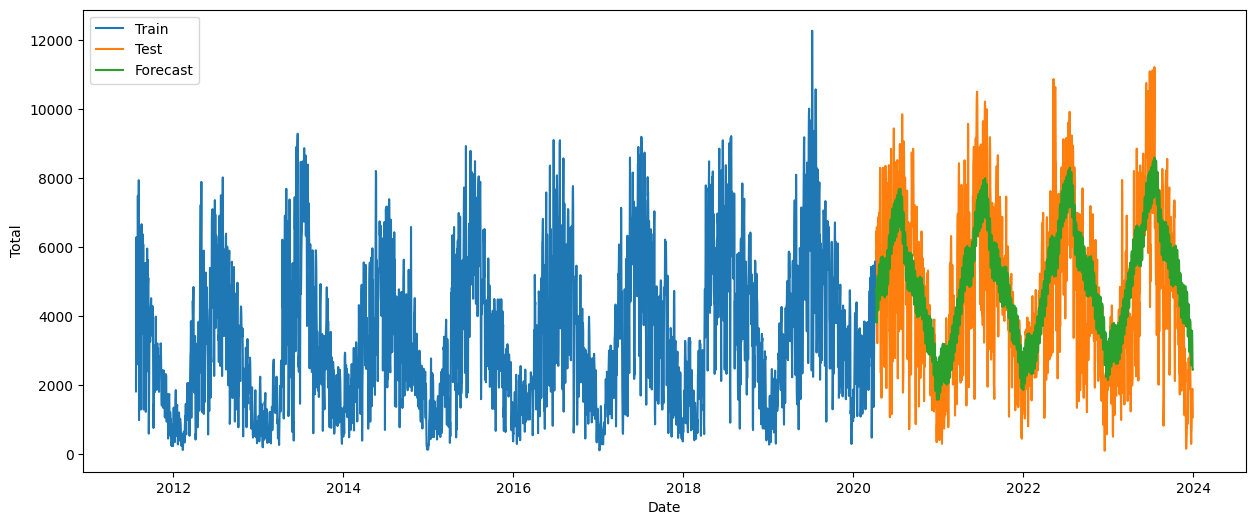

In [180]:
# split the data into train and test sets
train = df_prophet.iloc[:int(len(df_prophet)*0.7)]
test = df_prophet.iloc[int(len(df_prophet)*0.7):]

# Fit the model to the training data
model = Prophet()
model.fit(train)

# Make predictions
future = test.drop('y', axis=1)
forecast = model.predict(future)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
mae = mean_absolute_error(test['y'], forecast['yhat'])
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

# Visualize the forecast using matplotlib
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], forecast['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.show()


## Part 2 - Improving the model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/3pduqv36.json
DEBUG:cmdstanpy:input tempfile: /var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/f1cvxlcs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/caropaez/anaconda3/envs/thesis_env/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81535', 'data', 'file=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/3pduqv36.json', 'init=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/f1cvxlcs.json', 'output', 'file=/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/tmpasbmcema/prophet_model2js11ipx/prophet_model-20240317191433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:14:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:14:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done pr

Test RMSE: 1150.824
Test MAE: 907.082


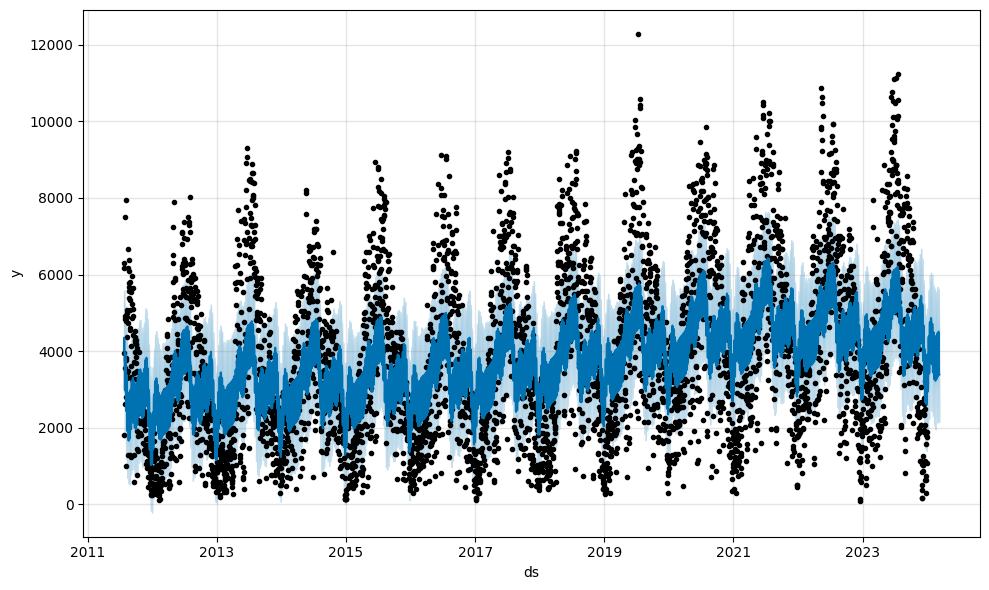

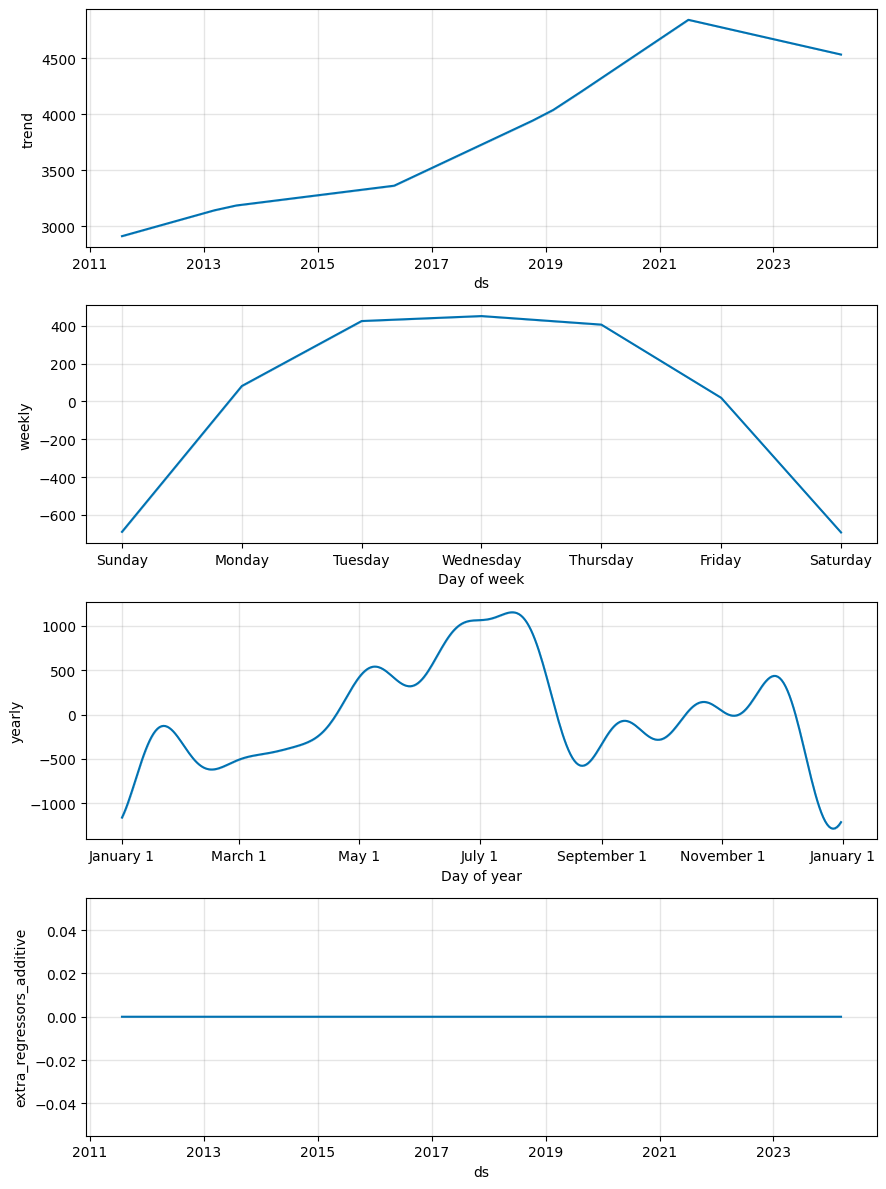

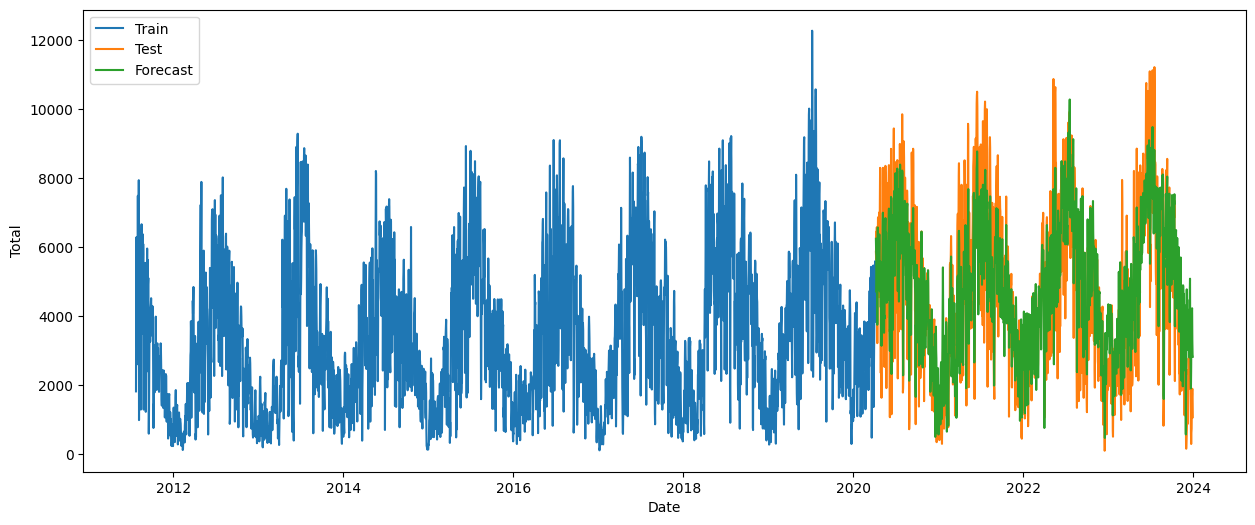

In [210]:
# Now we want to improve the model by adding the temperature and rainfall volume as additional regressors. We can do this by adding the columns to the dataframe before fitting the model.
# Prepare the data for the Prophet model
df_prophet = df_location_erhardt.reset_index()
df_prophet = df_prophet.rename(columns={'Date': 'ds', 'Total': 'y'})
df_prophet = df_prophet[['ds', 'y', 'MinTemp', 'MaxTemp', 'RainfallVolume']]
# We fit the model by instantiating a new `Prophet` object. Any settings to the forecasting procedure are passed into the constructor. Then you call its `fit` method and pass in the historical dataframe.
model = Prophet()
model.add_regressor('MinTemp')
model.add_regressor('MaxTemp')
model.add_regressor('RainfallVolume')
model.fit(df_prophet)

# Future dataframe with the dates for which we want a prediction
future = model.make_future_dataframe(periods=70)
future['MinTemp'] = df_location_erhardt['MinTemp'].values.mean()
future['MaxTemp'] = df_location_erhardt['MaxTemp'].values.mean()
future['RainfallVolume'] = df_location_erhardt['RainfallVolume'].values.mean()
future.tail()

# The `predict` method assigns each row in `future` a predicted value which it names `yhat`. If you pass in historical dates, it will provide an in-sample fit. The forecast object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)

# Plot the forecast components
fig2 = model.plot_components(forecast)

# split the data into train and test sets
train = df_prophet.iloc[:int(len(df_prophet)*0.7)]
test = df_prophet.iloc[int(len(df_prophet)*0.7):]

# Fit the model to the training data
model = Prophet()
model.add_regressor('MinTemp')
model.add_regressor('MaxTemp')
model.add_regressor('RainfallVolume')
model.fit(train)

# Make predictions
future = test.drop('y', axis=1)
future['MinTemp'] = test['MinTemp']
future['MaxTemp'] = test['MaxTemp']
future['RainfallVolume'] = test['RainfallVolume']
forecast = model.predict(future)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
mae = mean_absolute_error(test['y'], forecast['yhat'])
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

# Visualize the forecast using matplotlib
plt.figure(figsize=(15, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], forecast['yhat'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.show()

# XGBoost Model

In [284]:
# Now we will try the XGBoost model to forecast the total number of cyclists per day in Munich (Erhardt). 
# We will use the same features as in the Prophet model, i.e., the date, minimum temperature, maximum temperature, and rainfall volume.
from sklearn.model_selection import train_test_split

df = df_location_erhardt.copy()
X= df.drop('Total', axis=1)
y = df['Total']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the model parameters
# After trying different values for the parameters, the following values were found to give the best results
params = {
    'max_depth': 3,
    'eta': 0.21,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
num_rounds = 120

# Train the model
bst = xgb.train(params, dtrain, num_rounds)

# Predict the total number of cyclists per day
y_pred = bst.predict(dtest)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: %.3f' % mae)

Test RMSE: 757.609
Test MAE: 570.920


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MinTemp         60 non-null     float64
 1   MaxTemp         60 non-null     float64
 2   RainfallVolume  60 non-null     float64
 3   AvgTemp         60 non-null     float64
 4   DayOfWeek       60 non-null     int32  
 5   Month           60 non-null     int32  
 6   Year            60 non-null     int32  
dtypes: float64(4), int32(3)
memory usage: 2.7 KB
Predicted Total:      Predicted Total
0       3321.088379
1       3126.620605
2       3055.303955
3       3593.869385
4       2234.141602
5       1239.351196
6        940.586853
7       2217.246582
8       1884.654785
9       1820.467163
10      1805.588989
11      1917.089111
12       758.211853
13      1426.208618
14      2312.072754
15      2220.174316
16      2411.272461
17      2557.149902
18      1917.089111
19      1163.273560
20   

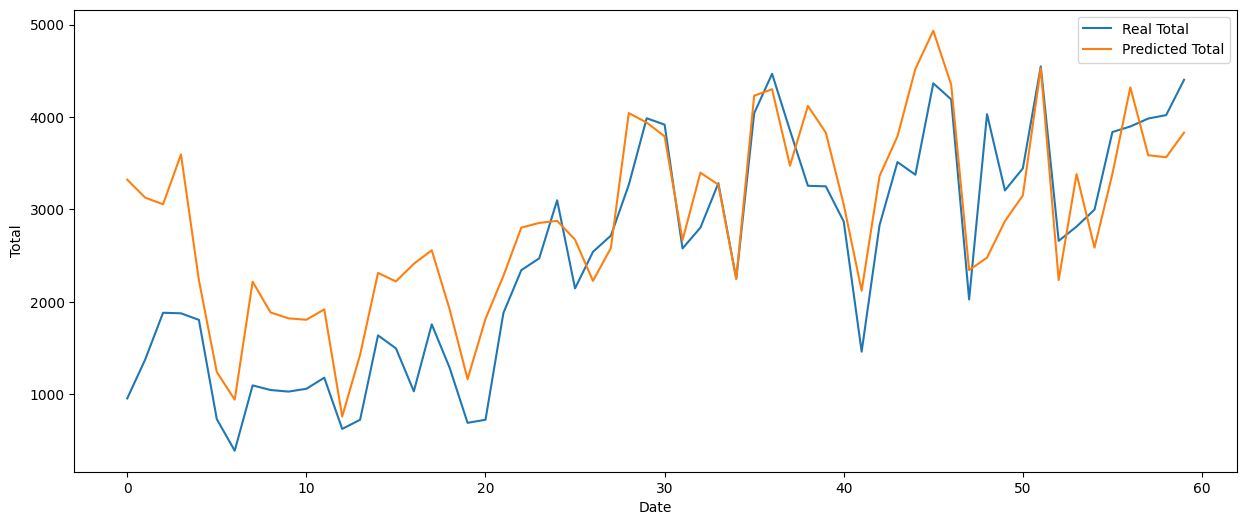

In [286]:
# Example new data preparation
newdata = './munich2024.csv'
new_df = pd.read_csv(newdata)

real_values = new_df['gesamt']
# List of columns to drop, as they are not needed for the analysis and visualization of the data
columns_to_drop = ['uhrzeit_start', 'zaehlstelle', 'uhrzeit_ende', 'richtung_1', 'richtung_2', 'bewoelkung', 'sonnenstunden', 'gesamt']

# Rename the columns to make them more readable and easier to work with
new_df = new_df.rename(columns={
    'datum':'Date',  # Change the column name to 'datum' to match the existing data
    'min-temp':'MinTemp',
    'max-temp':'MaxTemp',
    'niederschlag':'RainfallVolume'})

# Calculate the avaerage temperature from min and max temperature columns and add it to the dataframe as a new column called 'AvgTemp'
new_df['AvgTemp'] = (new_df['MinTemp'] + new_df['MaxTemp']) / 2

# Round the average temperature to one decimal place
new_df['AvgTemp'] = new_df['AvgTemp'].round(1)

# Convert the date column to datetime format
new_df['Date'] = pd.to_datetime(new_df['Date'])
# Add a calculated column for the Day of the Week
new_df['DayOfWeek'] = new_df['Date'].dt.dayofweek + 1  # Adding 1 to have Monday as 1
# Add a calculated column for the Month
new_df['Month'] = new_df['Date'].dt.month
# Add a calculated column for the Year
new_df['Year'] = new_df['Date'].dt.year

# Drop the columns that are not needed
new_df = new_df.drop(columns=columns_to_drop+['Date'])

new_df.info()
# Convert the new data into DMatrix format
dnew = xgb.DMatrix(new_df)

# Use the trained model to make predictions
new_preds = bst.predict(dnew)
new_preds = pd.DataFrame(new_preds, columns=['Predicted Total'])
print("Predicted Total: ", new_preds)
print("Real Total: ", real_values)

# Calculate the error metrics
rmse = np.sqrt(mean_squared_error(real_values, new_preds))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(real_values, new_preds)
print('Test MAE: %.3f' % mae)

# Visualize the predictions
plt.figure(figsize=(15, 6))
plt.plot(real_values, label='Real Total')
plt.plot(new_preds, label='Predicted Total')
plt.xlabel('Date')
plt.ylabel('Total')
plt.legend()
plt.show()


# TCN

In [19]:
import pandas as pd
from datetime import datetime

# Load the training data
training_data_path = './munich_erhardt.csv'
training_data = pd.read_csv(training_data_path)
# Load the testing data
testing_data_path = './munich2024.csv'
testing_data = pd.read_csv(testing_data_path)

# Preprocessing training data: No major preprocessing needed beyond what's already discussed

# Preprocessing testing data
# Convert 'Date' format in testing data to match the training data format
testing_data['Date'] = pd.to_datetime(testing_data['Date'], format='%Y.%m.%d').dt.strftime('%Y-%m-%d')

# Selecting relevant columns (excluding 'bewoelkung' and 'sonnenstunden' for consistency with training data)
testing_data_relevant = testing_data[['Date', 'Total', 'MinTemp', 'MaxTemp', 'RainfallVolume']].copy()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Feature engineering for dates
training_data['Date'] = pd.to_datetime(training_data['Date'])
testing_data_relevant['Date'] = pd.to_datetime(testing_data_relevant['Date'])

# Extract day of year as a cyclical feature
training_data['DayOfYear'] = training_data['Date'].dt.dayofyear
testing_data_relevant['DayOfYear'] = testing_data_relevant['Date'].dt.dayofyear

# Normalize weather conditions and day of year feature
features_to_scale = ['MinTemp', 'MaxTemp', 'RainfallVolume', 'DayOfYear']
scaler = StandardScaler()

# Fit on training data
training_data_scaled = scaler.fit_transform(training_data[features_to_scale])
training_data_scaled = np.concatenate([training_data_scaled, training_data[['Total']].values], axis=1)

# Transform testing data
testing_data_scaled = scaler.transform(testing_data_relevant[features_to_scale])
testing_data_scaled = np.concatenate([testing_data_scaled, testing_data_relevant[['Total']].values], axis=1)

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(training_data_scaled[:, :-1], training_data_scaled[:, -1], test_size=0.2, random_state=42)

# Output the shapes of the datasets as a sanity check
X_train.shape, X_val.shape, testing_data_scaled.shape

((3634, 4), (909, 4), (60, 5))

Epoch 1/100
114/114 [==============================] - 0s 1ms/step - loss: 18268168.0000 - val_loss: 6676519.0000
Epoch 2/100
114/114 [==============================] - 0s 649us/step - loss: 2660137.0000 - val_loss: 1876658.2500
Epoch 3/100
114/114 [==============================] - 0s 654us/step - loss: 1832256.1250 - val_loss: 1693675.5000
Epoch 4/100
114/114 [==============================] - 0s 646us/step - loss: 1666203.1250 - val_loss: 1627402.0000
Epoch 5/100
114/114 [==============================] - 0s 664us/step - loss: 1588882.6250 - val_loss: 1592171.1250
Epoch 6/100
114/114 [==============================] - 0s 671us/step - loss: 1556979.6250 - val_loss: 1582595.3750
Epoch 7/100
114/114 [==============================] - 0s 639us/step - loss: 1534820.3750 - val_loss: 1599394.7500
Epoch 8/100
114/114 [==============================] - 0s 671us/step - loss: 1526559.5000 - val_loss: 1564829.1250
Epoch 9/100
114/114 [==============================] - 0s 659us/step - loss: 1514

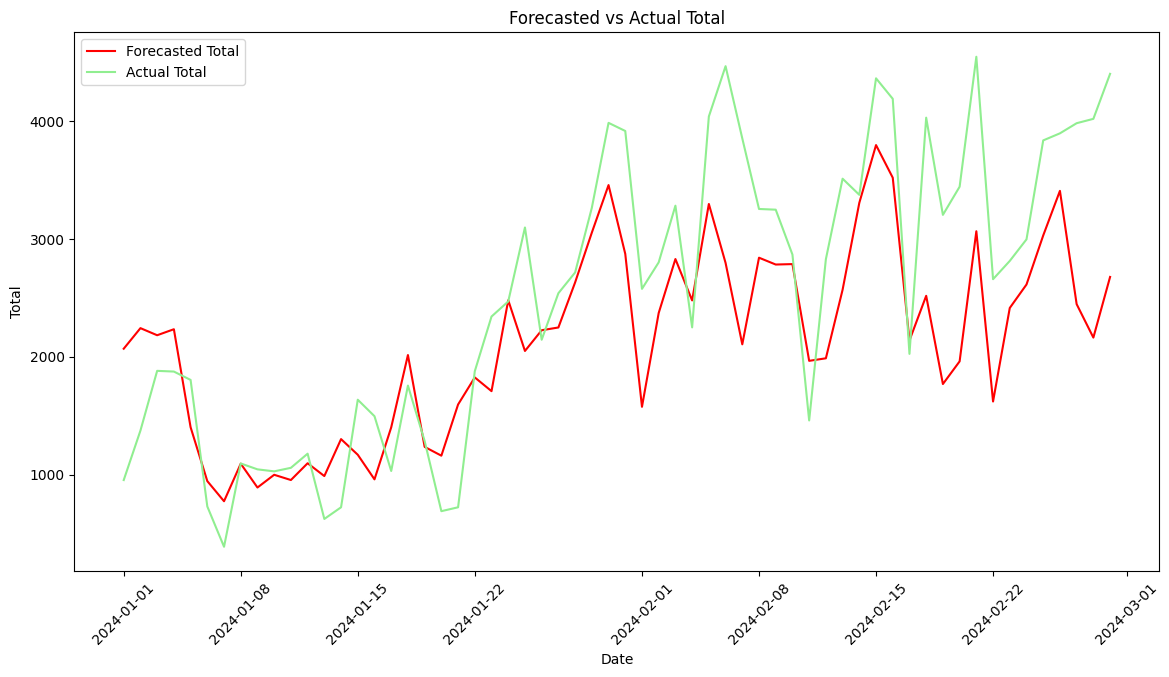

In [20]:
# Defining the TCN model
import tensorflow as tf
from tensorflow.keras import layers

def build_tcn_model(input_shape):
    i = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(i)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.Dense(1)(x)
    model = tf.keras.Model(i, x)
    model.compile(optimizer='adam', loss='mse')
    return model

# Build the TCN model
model = build_tcn_model(input_shape=X_train.shape[1])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)

# Evaluate the model on the testing data
test_loss = model.evaluate(testing_data_scaled[:, :-1], testing_data_scaled[:, -1])
test_loss

# Make predictions on the testing data
predictions = model.predict(testing_data_scaled[:, :-1])

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame({'Date': testing_data_relevant['Date'], 'Forecasted_Total': predictions.flatten()})
predictions_df.head()

# Plot the forecasted and actual values
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['Date'], predictions_df['Forecasted_Total'], label='Forecasted Total', color='red')
plt.plot(testing_data_relevant['Date'], testing_data_relevant['Total'], label='Actual Total', color='lightgreen')
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Forecasted vs Actual Total')
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [21]:
# Calculate error metrics
mse = mean_squared_error(testing_data_relevant['Total'], predictions_df['Forecasted_Total'])
mae = mean_absolute_error(testing_data_relevant['Total'], predictions_df['Forecasted_Total'])
rmse = np.sqrt(mse)

# Print the error metrics
print(f'MSE: {mse}, MAE: {mae}, RMSE: {rmse}')

MSE: 640948.8794932176, MAE: 617.5837483723958, RMSE: 800.5928300286092


# Hourly Data

Analyzing hourly bicycle count data, as opposed to daily aggregates, can provide much deeper insights into cycling patterns and behaviors, offering valuable information for urban planning, infrastructure development, and cycling promotion strategies

- Currently for 2022 -> do also 2020

In [5]:
# Load the data
munich2022_15min = "./munich_2022_15min.csv"
munich_2022_15min = pd.read_csv(munich2022_15min)

# Drop the columns that are not needed
munich_2022_15min = munich_2022_15min.drop(columns=['t', 'richtung_1', 'richtung_2', 'kommentar'])

# Rename the columns to make them more readable and easier to work with
munich_2022_15min = munich_2022_15min.rename(columns={
    'datum':'Date',
    'zaehlstelle': 'Location',
    'gesamt':'Total',
    'uhrzeit_start':'TimeStampStart',
    'uhrzeit_ende':'TimeStampEnd',
    'Niederschlag':'RainfallVolume'})


# Create a new dataframe for the selected location (Erhardt) and reset the index
Erhardt_2022_15min = munich_2022_15min[munich_2022_15min['Location']=='Erhardt'].reset_index()
Erhardt_2022_15min = Erhardt_2022_15min.drop(columns=['Location','index'])


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_36826/4122069900.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  munich_2022_15min = pd.read_csv(munich2022_15min)


In [6]:
import pandas as pd
from datetime import datetime

print(Erhardt_2022_15min.head())
Erhardt_2022_15min.info()

# Make sure 'Date' is in datetime format
Erhardt_2022_15min['Date'] = pd.to_datetime(Erhardt_2022_15min['Date'])

# Convert 'TimeStampStart' to datetime to extract time
Erhardt_2022_15min['TimeStampStart'] = pd.to_datetime(Erhardt_2022_15min['TimeStampStart'], format='%H:%M').dt.time

# Create 'DateTime' by combining 'Date' and 'TimeStampStart'
Erhardt_2022_15min['DateTime'] = Erhardt_2022_15min.apply(lambda row: datetime.combine(row['Date'].date(), row['TimeStampStart']), axis=1)

# Set 'DateTime' as the index
Erhardt_2022_15min.set_index('DateTime', inplace=True)

# Resample and aggregate to hourly totals
hourly_data = Erhardt_2022_15min['Total'].resample('H').sum()

# Reset index if you want 'DateTime' back as a column
hourly_data = hourly_data.reset_index()

hourly_data.head()


         Date TimeStampStart TimeStampEnd  Total
0  2022-01-01          00:00        00:15    4.0
1  2022-01-01          00:15        00:30    5.0
2  2022-01-01          00:30        00:45   13.0
3  2022-01-01          00:45        01:00    8.0
4  2022-01-01          01:00        01:15    5.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            35040 non-null  object 
 1   TimeStampStart  35040 non-null  object 
 2   TimeStampEnd    35040 non-null  object 
 3   Total           35040 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


/var/folders/ch/91lhzbmj5qz7s7pzsvt5_5t00000gn/T/ipykernel_36826/288799845.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_data = Erhardt_2022_15min['Total'].resample('H').sum()


,DateTime,Total
0,2022-01-01 00:00:00,30.0
1,2022-01-01 01:00:00,46.0
2,2022-01-01 02:00:00,90.0
3,2022-01-01 03:00:00,44.0
4,2022-01-01 04:00:00,27.0


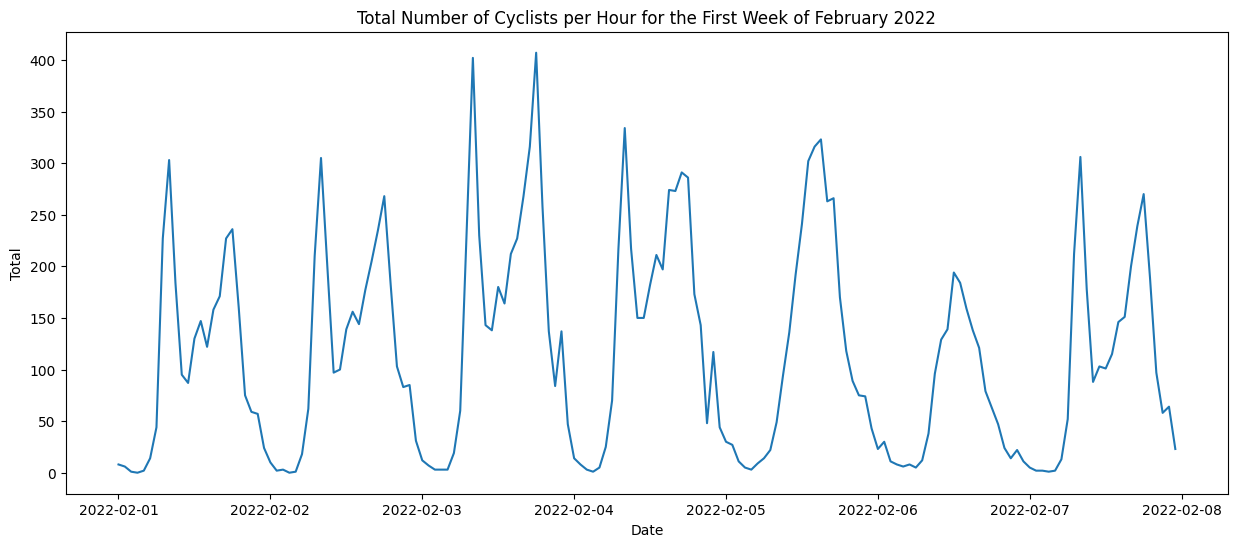

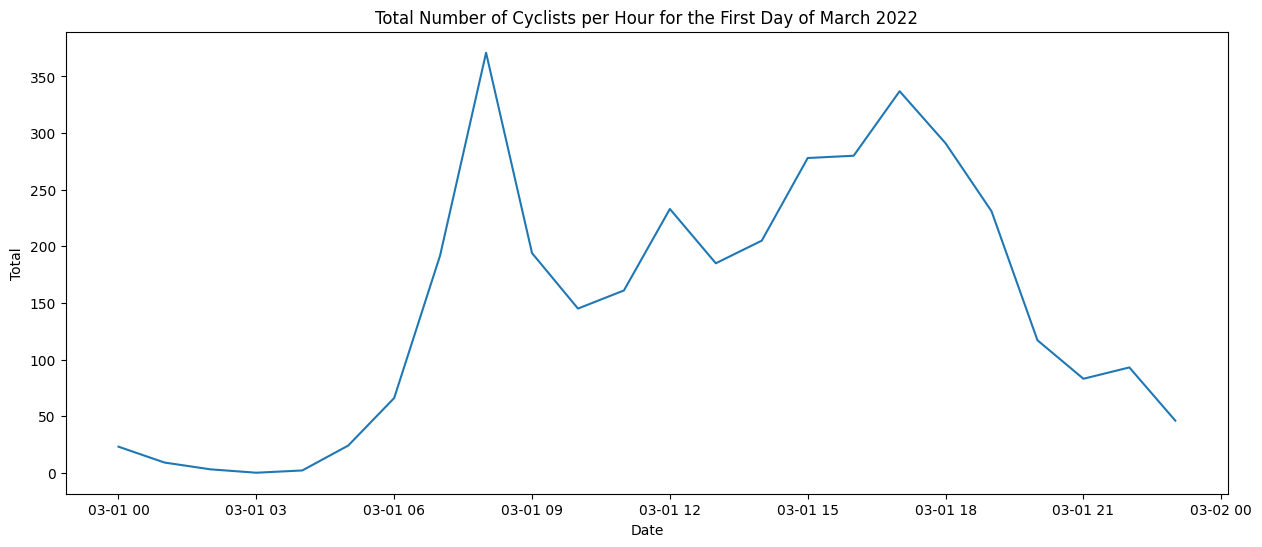

In [365]:
# Create a new data frame with the date and total number of cyclists per day for the first week of February 2022
first_week = hourly_data[(hourly_data['DateTime'] >= '2022-02-01') & (hourly_data['DateTime'] < '2022-02-08')]
first_week = first_week.set_index('DateTime')

# Plot the total number of cyclists per hour for the first week of February 2022
plt.figure(figsize=(15, 6))
plt.plot(first_week.index, first_week['Total'])
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Total Number of Cyclists per Hour for the First Week of February 2022')
plt.show()

# Create a new data frame with the date and total number of cyclists for the first day of march 2022
first_day_march = hourly_data[(hourly_data['DateTime'] >= '2022-03-01') & (hourly_data['DateTime'] < '2022-03-02')]
first_day_march = first_day_march.set_index('DateTime')

# Plot the total number of cyclists per hour for the first day of March 2022
plt.figure(figsize=(15, 6))
plt.plot(first_day_march.index, first_day_march['Total'])
plt.xlabel('Date')
plt.ylabel('Total')
plt.title('Total Number of Cyclists per Hour for the First Day of March 2022')
plt.show()



## 1. Hourly Traffic Patterns
Identify peak cycling hours throughout the day and understand how these patterns vary across different days of the week or seasons. This can help in optimizing traffic management and cycling infrastructure maintenance schedules.

In [367]:
# First we want to extract the hour from the 'DateTime' column and add it as a new column called 'Hour'
hourly_data['Hour'] = hourly_data['DateTime'].dt.hour

# Extract the day of the week from the 'DateTime' column and add it as a new column called 'DayOfWeek'
hourly_data['DayOfWeek'] = hourly_data['DateTime'].dt.dayofweek + 1  # Adding 1 to have Monday as 1

# Extract the month from the 'DateTime' column and add it as a new column called 'Month'
hourly_data['Month'] = hourly_data['DateTime'].dt.month

# Extract the year from the 'DateTime' column and add it as a new column called 'Year'
hourly_data['Year'] = hourly_data['DateTime'].dt.year

# Group so that we can calculte the average number of cyclists per hour for each day of the week depending on the month
grouped = hourly_data.groupby(['Month', 'DayOfWeek', 'Hour'])['Total'].mean()
print(grouped)

# Defining colors for each day of the week
colors = ['darkorange', 'lightsalmon', 'coral', 'red', 'wheat', 'seagreen', 'mediumaquamarine']


Month  DayOfWeek  Hour
1      1          0        4.60
                  1        3.80
                  2        0.80
                  3        0.60
                  4        2.20
                          ...  
12     7          19      38.50
                  20      29.25
                  21      23.50
                  22      22.50
                  23      11.75
Name: Total, Length: 2016, dtype: float64


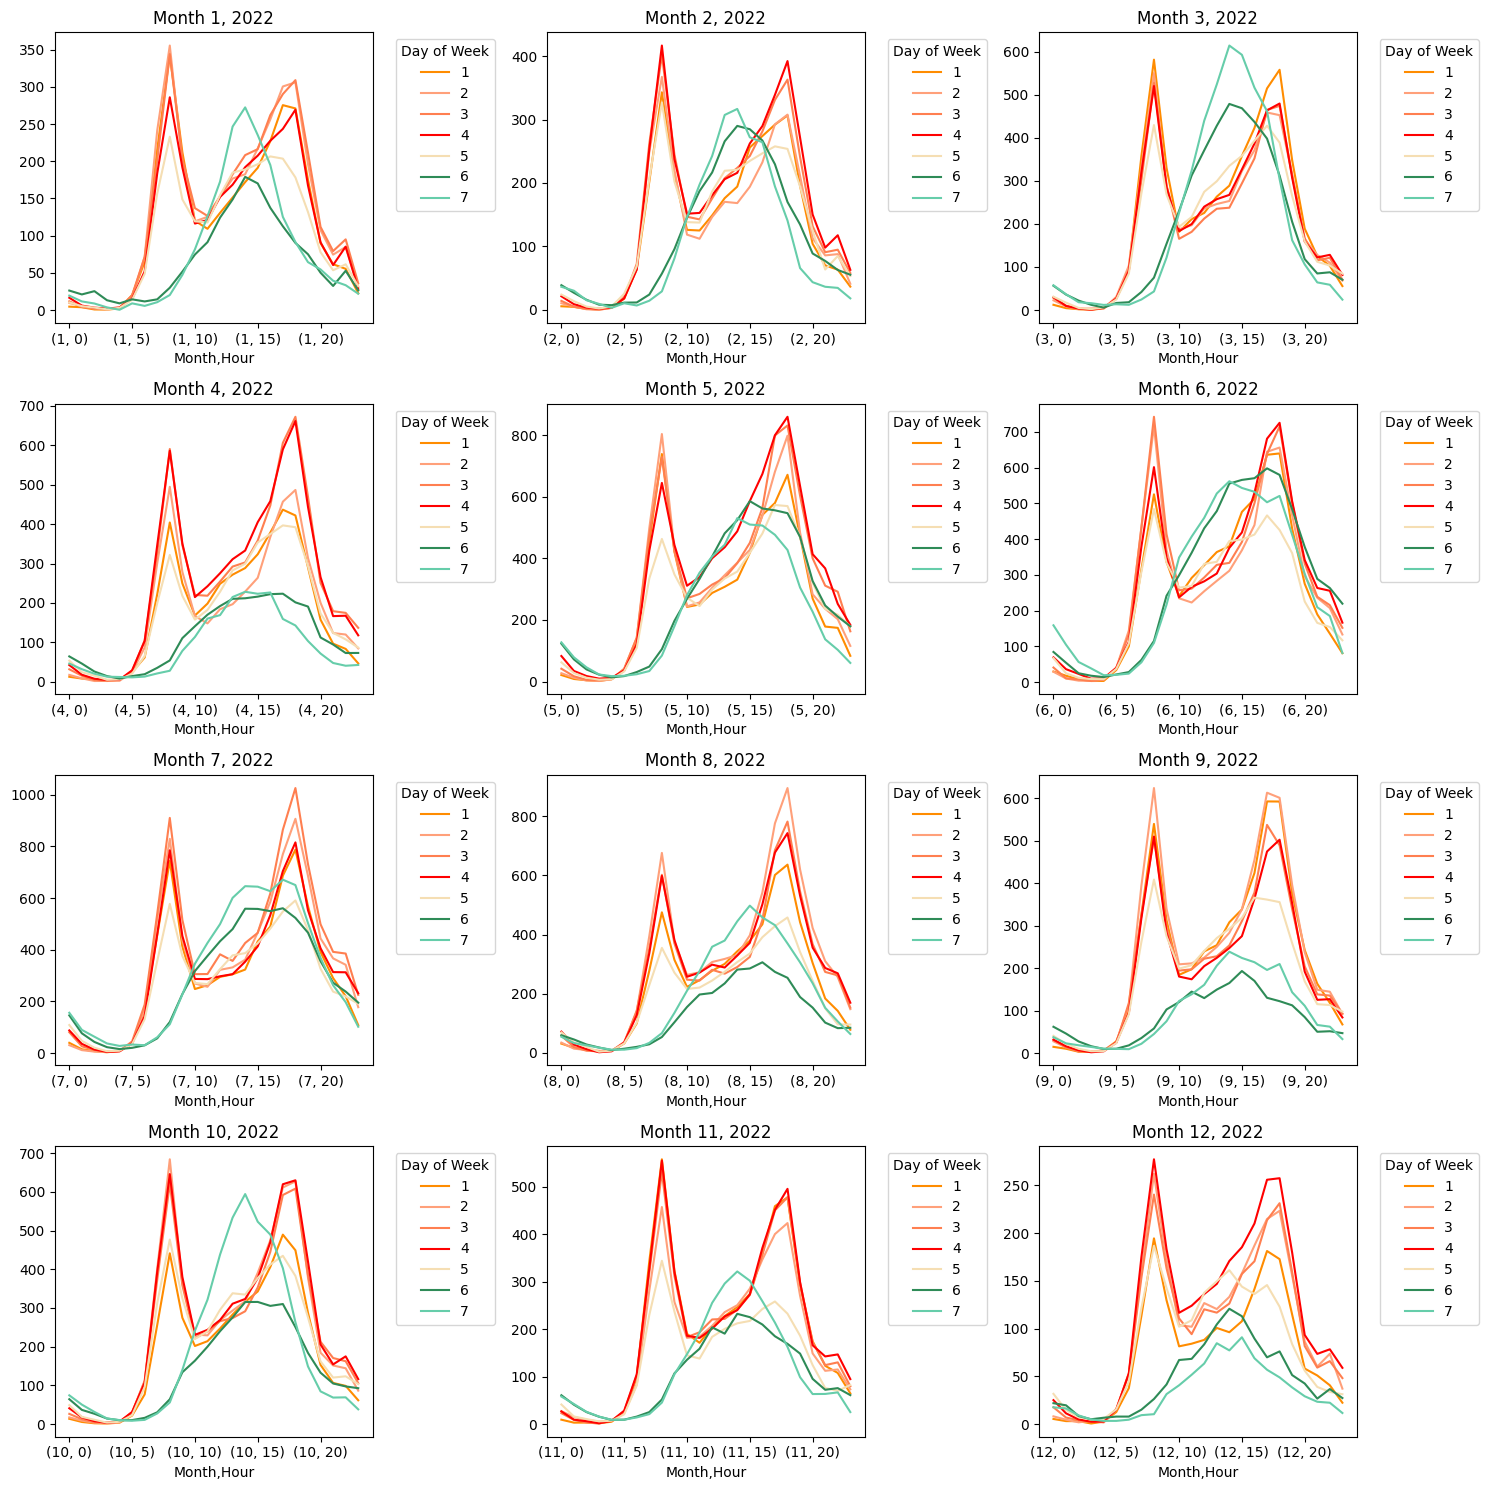

In [370]:
# Plot the average number of cyclists per hour for each day of the week depending on the month in 12 subplots with different colors for each day of the week
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

# Adjust the loop to iterate over months only, given your subplot configuration
for month, data in grouped.groupby(level=0):
    ax = axes[(month-1) // 3, (month-1) % 3]  # Calculate subplot position
    month_data = data.unstack(level=1)  # Unstack to get day of week on one level
    month_data.plot(ax=ax, title=f'Month {month}, 2022', color=colors)
    ax.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')
    
plt.tight_layout()
plt.show()


- Commuting Patterns: We see peaks during typical commuting hours on weekdays. This helps us to get an idea of higher cycling activity related to work/school commutes.
- Recreational Patterns: Late morning to afternoon on the weekend peaks might indicate more recreational activity. The distribution is  wider than commuting patterns, reflecting a more flexible schedule.

## 2. Commuting vs. Recreational Cycling
Differentiate between commuting patterns, typically observed during morning and evening rush hours, and recreational cycling, which might peak during weekends or late afternoons. This distinction can inform targeted infrastructure improvements and promotional activities.
<br><br>
This analysis involves identifying key time periods and days that are indicative of commuting and recreational activities, respectively.

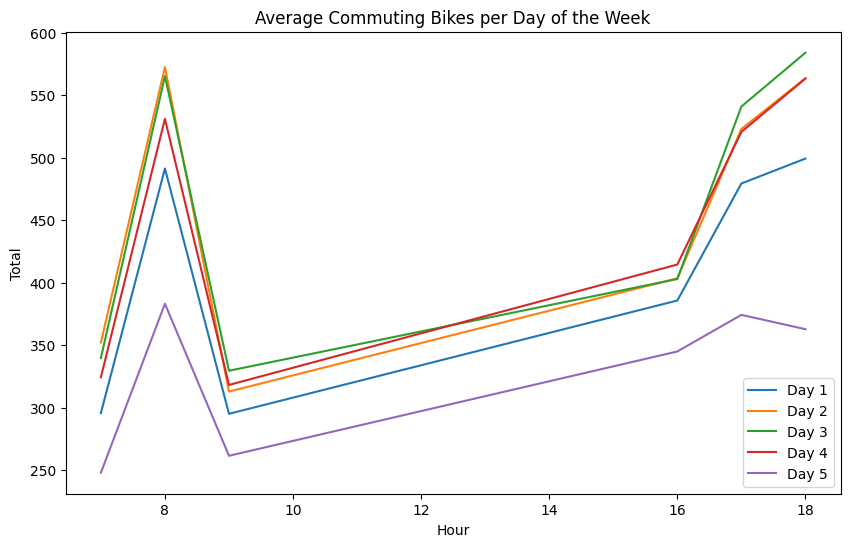

In [380]:
# First we need to define commuting and recreational windows
# Commuting hours: 7AM to 9AM and 4PM to 6PM on weekdays
commuting = hourly_data[(hourly_data['DayOfWeek'] <= 5) & (
                        ((hourly_data['Hour'] >= 7) & (hourly_data['Hour'] <= 9)) |
                        ((hourly_data['Hour'] >= 16) & (hourly_data['Hour'] <= 18)))]

non_commuting = hourly_data[(hourly_data['DayOfWeek'] > 5) & (
                        (hourly_data['Hour'] < 7) | (hourly_data['Hour'] >18) |
                        ((hourly_data['Hour'] > 9) & (hourly_data['Hour'] < 16)))]

# Aggregate the data by commuting and non-commuting patterns to calculate the average
avg_commuting = commuting.groupby(['DayOfWeek', 'Hour'])['Total'].mean().reset_index()
avg_non_commuting = non_commuting.groupby(['DayOfWeek', 'Hour'])['Total'].mean().reset_index()

# Visualize
plt.figure(figsize=(10,6))

# Unique days of the week
days = avg_commuting['DayOfWeek'].unique()

for day in days:
    data = avg_commuting[avg_commuting['DayOfWeek'] == day]
    sns.lineplot(x='Hour', y='Total', data=data, label=f'Day {day}')
    
plt.title('Average Commuting Bikes per Day of the Week')
plt.legend()
plt.show()

## 3. Effect of Daylight and Seasonal Changes
Analyze how daylight hours influence cycling activity, particularly how patterns shift with the changing length of the day across seasons. This can guide lighting and safety measures for cyclists.

## 4. Impact of Public Events and Holidays
Investigate the impact of local events, public holidays, or school vacations on cycling traffic, potentially identifying times when additional bicycle parking or temporary lanes might be needed.